# Pressure drop in 3d printed ventilator restrictor

Dr Daniel Duke<br>
Laboratory for Turbulence Research in Aerospace & Combustion (LTRAC)<br>
Department of Mechanical & Aerospace Engineering<br>
Monash University<br>

27th March 2020

Here, we will use simple pipe friction factor calculations to estimate the expected pressure drop for steady flow in a straight pipe to model the ventilator restrictor.


In [1]:
# Import libraries
import numpy as np
import copy, datetime
import scipy.optimize as sopt
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
# Colebrook function for friction factor in turbulent incompressible round pipe flow
# Assume that e (roughness) and D are constants but ReD is a vector
def fColebrook(e,D,ReD):
    
    def fun(f,e,D,Rey):
        f = np.abs(f) # f can't be negative
        logarg = (e/D/3.7) + (2.51/np.nan_to_num(Rey)/f**0.5)  # arg to natural log
        logarg = np.nan_to_num(logarg)
        fmin = (f**-0.5) + 2*np.log(logarg * (logarg>0)) # function to minimize, checking for no log(-ve)
        fmin += 1e6*(-logarg)*(logarg<0) # penalize negative logarg
        return fmin
    
    solutions = []
    for Rey in ReD:
        root = sopt.fsolve(fun,x0=0.01,args=(e,D,Rey))
        #print(Rey,root[0]) # debugging
        solutions.append( np.abs(root[0]) )
    
    return solutions

In [92]:
# Define some variables and constants

# Imposed flowrate, Litres per minute-
flowRateVals = np.concatenate((np.arange(1.0,10.0,0.5),\
                               np.arange(10.0,130.0,5.)))
                               
L = 50e-3  # metres, restriction length
D0 = 22e-3 # metres, diameter of upstream & downstream pipe near restriction
nu = 1.56e-5 # m^2/s
T = 25 # degrees C
R = 287 # J/kg-K for air
gamma = 1.4 # for air
rho_0 = 1.22 # kg/m3 for air at rest
date=datetime.datetime.now().date()
colormap=plt.cm.rainbow

In [19]:
# Run flow rate sweep for one restriction diameter D
def do_dp_calc(D,flowRateVals,roughness):

    # Make copy of flowRate so we can delete invalid entries
    flowRate = copy.copy(flowRateVals)
    
    # Calculate parameters based on variables and constants
    pipeArea = np.pi * 0.25 * D**2 # m^2
    Ubar = flowRate*1.66667e-5/pipeArea #  bulk velocity [m/s]
    SoS = np.sqrt(gamma*R*(273.15+T)) # sound speed
    Mach = Ubar / SoS # Mach number

    # Limit velocity and flow rate in the case of choking?
    #Ubar[Mach>1] = 0 # Choked flow limit, straight pipe (no supersonic section)
    #flowRate[Mach>1] = 0 #SoS*pipeArea/1.66667e-5 # Update flow rate for choked flow
    
    # Get the inlet/outlet pipe velocity
    U0 = flowRate*1.66667e-5/(np.pi * 0.25 * D0**2 ) # [m/s]

    ReD = Ubar * D / nu # Reynolds number [-]

    # Compressibility correction
    rho = rho_0 * (1 + (gamma-1)*0.5*Mach**2)**(-1/(gamma-1))
    #rho = rho_0 * np.ones_like(ReD) # no compressibility corr.

    if roughness/D < 0.05:
        Re_transition = 2914.3797 # In the limit of a smooth wall, from below fn.
    else:
        Re_transition = 600 + (0.972*(roughness/D)+0.027)**-3 # Approximation for rough walls
    
    # Solve for friction factors
    turbulent = np.nan_to_num(ReD)>=Re_transition # where turbulent or transitional flow likely
    f = 64/(ReD+1e-6)  # Laminar solution - incompressible
    f[turbulent] = fColebrook(roughness,D,ReD[turbulent]) # turbulent solution - incompressible
        
    # Solve for pressure drop just in the straight pipe restriction
    dP_pipe = f*(L/D)*(rho*Ubar**2)*0.5 # Pascal

    # Solve for pressure drop in sharp exit condition
    KL_exit = np.ones_like(Ubar) * (1 - (D**2 / D0**2))**2
    dP_exit = KL_exit * rho * 0.5 * U0**2 # Pascal

    # Solve for pressure drop in concical entry condition
    KL_entry = 1.0 # based on a 30 degree cone - Munson & White page 486
    dP_entry = KL_entry * rho * 0.5 * U0**2

    dP_pipe *= 0.0101972 # in cm of H2O
    dP_exit *= 0.0101972 # in cm of H2O
    dP_entry *= 0.0101972 # in cm of H2O

    return flowRate, dP_pipe, dP_exit, dP_entry, f, rho, turbulent

<IPython.core.display.Javascript object>


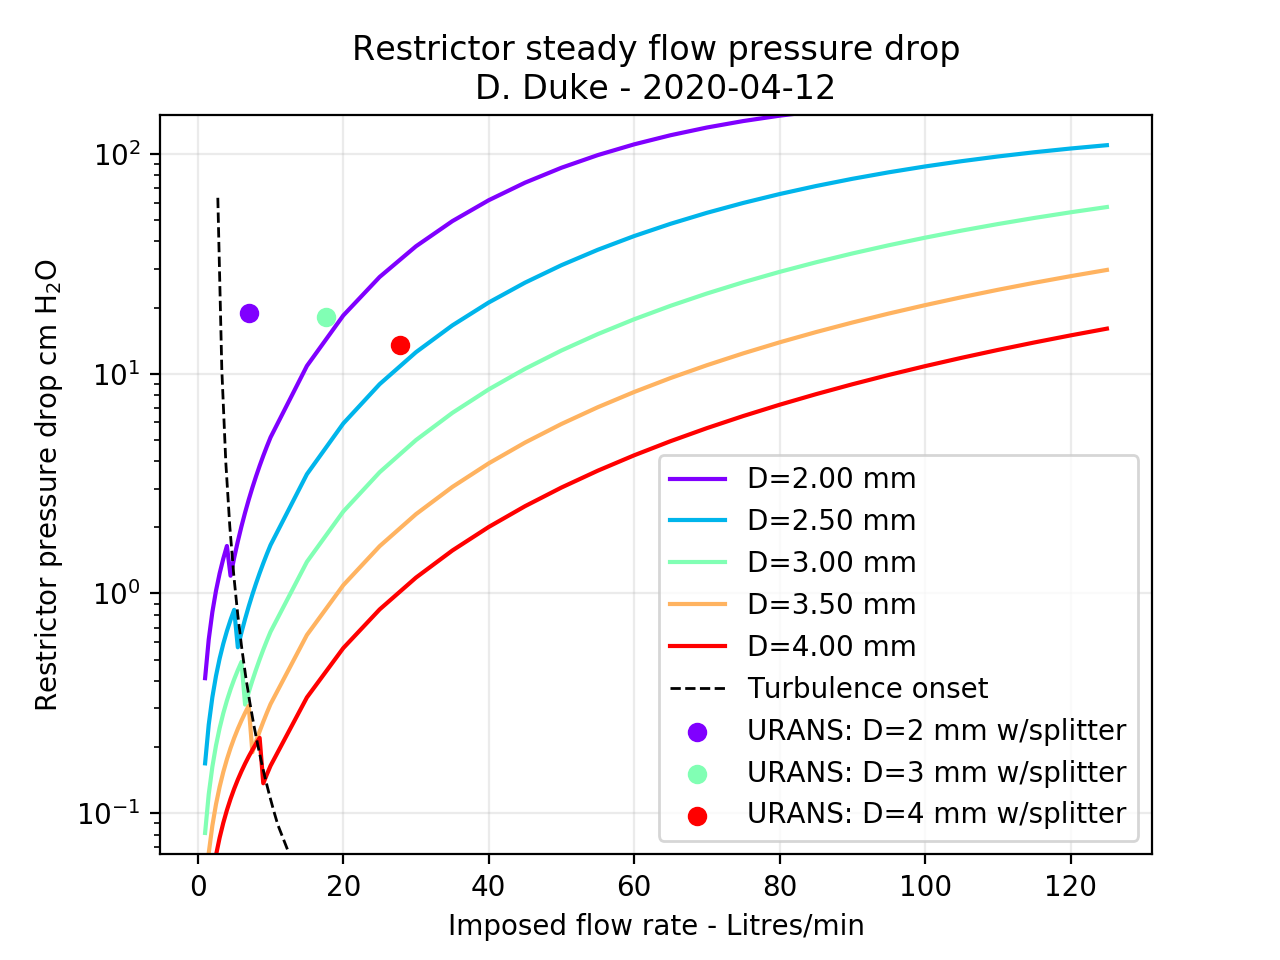

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in power


In [121]:
# THIS CODE BLOCK WILL SWEEP VARIOUS RESTRICTION DIAMETERS

#D_vals = np.arange(2.75e-3,5e-3,2.5e-4)  # metres, diameter of restriction
D_vals = np.array((2e-3,2.5e-3,3e-3,3.5e-3,4e-3))

roughness = 50e-6 # units metres

dP_results = []
turbulence_onset = []
for D in D_vals:
    
    # Run the main loop
    flowRate, dP_pipe, dP_exit, dP_entry, f, rho, turbulent = do_dp_calc(D,flowRateVals,roughness)
    #print(D,np.nanmax(dP_exit/dP_pipe), np.nanmax(dP_entry/dP_pipe))

    # Final results
    dP = dP_pipe + dP_exit + dP_entry

    dP_results.append(dP)
    
    # Find onset of turbulence
    to = np.where(turbulent==True)[0][0]
    turbulence_onset.append( (flowRate[to], dP[to]) )
    
# Plot the results

fig=plt.figure()
ax=fig.add_subplot(111)
plt.grid(alpha=.25)
plt.xlabel('Imposed flow rate - Litres/min')
plt.ylabel('Restrictor pressure drop cm H$_2$O')
plt.title("Restrictor steady flow pressure drop\nD. Duke - %s" % date)
colormap_intervals = np.linspace(0, 1, len(dP_results))
colors = [colormap(x) for x in colormap_intervals]
for i in range(len(dP_results)):
    ax.plot(flowRateVals,dP_results[i],label='D=%.2f mm' % (D_vals[i]*1e3),color=colors[i])
    #if i==len(dP_results)-1: l='Turbulence onset'
    #else: l=None
    #ax.scatter(*turbulence_onset[i],label=l,marker='+')
    #ax.axvline(turbulence_onset[i][0],label=l,ls='--',lw=1)

# Add some known data from OpenFOAM
ax.scatter((6.97),(18.82),c=(colors[0],),label='URANS: D=2 mm w/splitter') # 2mm
ax.scatter((np.nan),(np.nan))
ax.scatter((17.59),(18.03),c=(colors[2],),label='URANS: D=3 mm w/splitter') # 3mm
ax.scatter((np.nan),(np.nan))
ax.scatter((27.8),(13.45),c=(colors[4],),label='URANS: D=4 mm w/splitter') # 4mm
    
def myfun(x,a,b,c): return (a*x+b)**-(np.abs(c))
popt, pcov = sopt.curve_fit(myfun,[turbulence_onset[i][0] for i in range(len(dP_results))],\
                            [turbulence_onset[i][1] for i in range(len(dP_results))],p0=(1,0,-2),maxfev=10000)
ax.plot(flowRateVals[2:-10]*1.1,myfun(flowRateVals[2:-10],*popt),label='Turbulence onset',c='k',lw=1,ls='--')

plt.legend();
plt.yscale('log')
plt.ylim(0.065,150)
plt.savefig("/Users/dduke/Desktop/Colebrook_Estimate.pdf")

<IPython.core.display.Javascript object>


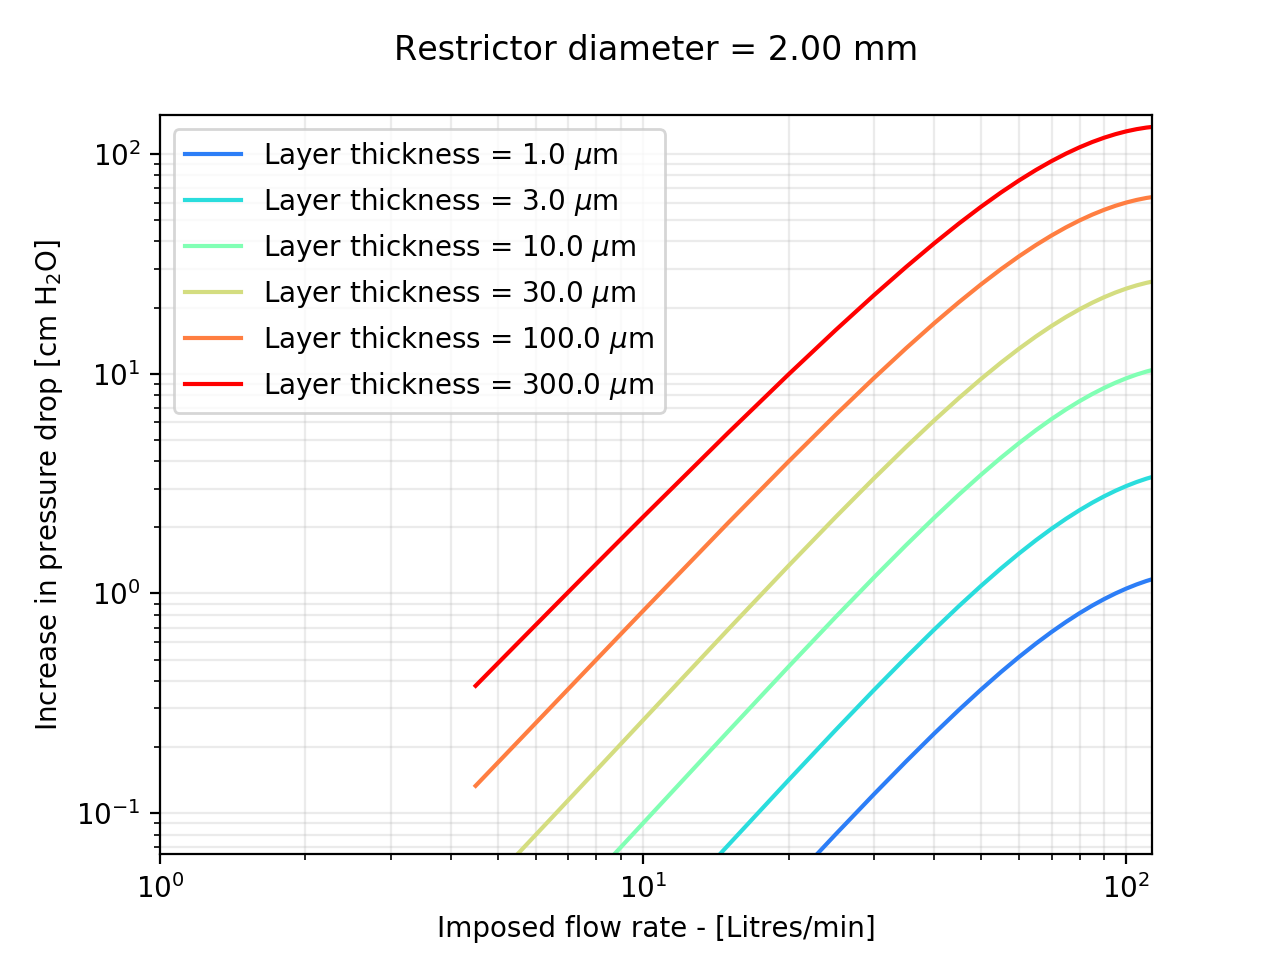

In [126]:
# THIS CODE BLOCK WILL SWEEP VARIOUS ROUGHNESSES

D=2e-3  # metres, diameter of restriction
roughness_vals=np.array((1e-10, 1e-6, 3e-6, 1e-5, 3e-5, 1e-4, 3e-4))

# Scale the layer height value to a roughness that can be used by the Colebrook Friction Factor.
roughness_scale=1/4.

subtract_baseline = True # find difference relative to first set of solutions?

dP_results = []
turbulence_onset = []
for roughness in roughness_vals:
    
    # Run the main loop
    flowRate, dP_pipe, dP_exit, dP_entry, f, rho, turbulent = do_dp_calc(D,flowRateVals,roughness*roughness_scale)
    #print(D,np.nanmax(dP_exit/dP_pipe), np.nanmax(dP_entry/dP_pipe))

    # Final results
    dP = dP_pipe + dP_exit + dP_entry

    dP_results.append(dP)
    
    # Find onset of turbulence
    to = np.where(turbulent==True)[0]
    if len(to)>0: turbulence_onset.append( (flowRate[to[0]], dP[to[0]]) )
    else: turbulence_onset.append((0,0))
        
        
# Plot the results
fig=plt.figure()
ax=fig.add_subplot(111)
plt.grid(alpha=.25,which='both')
plt.xlabel('Imposed flow rate - [Litres/min]')
plt.ylabel('Increase in pressure drop [cm H$_2$O]')
plt.title("Restrictor diameter = %.2f mm\n" % (D*1e3))
colormap_intervals = np.linspace(0, 1, len(dP_results))
colors = [colormap(x) for x in colormap_intervals]
for i in range(len(dP_results)):
    if not subtract_baseline or i>0:

        if roughness_vals[i] < 1e-3:
            label='Layer thickness = %.1f $\\mu$m' % (roughness_vals[i]*1e6)
        else:
            label='Layer thickness = %.1f mm' % (roughness_vals[i]*1e3)

        if subtract_baseline:
            dP_calc = dP_results[i]-dP_results[0]
            dP_calc[dP_calc<=0]=np.nan
            ax.plot(flowRateVals,dP_calc,label=label,color=colors[i])
        else:
            ax.plot(flowRateVals,dP_results[i],label=label,color=colors[i])

plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlim(1,113)
plt.ylim(0.065,150)
plt.savefig("/Users/dduke/Desktop/RoughnessEffect_D%0.2f_mm.pdf" % D)
#plt.axvline(4.5,ls='--',c='k',lw=1)